In [41]:
try:
    import jax
    import jax.numpy as jnp
except:
    ModuleNotFoundError
    %pip install jax jaxlib
    import jax
    import jax.numpy as jnp

try:
    from tensorflow_probability.substrates import jax as tfp
except:
    ModuleNotFoundError
    %pip install tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp
    
try:
    import daft
except:
    ModuleNotFoundError
    %pip install daft
    import daft

try:
    import optax
except:
    ModuleNotFoundError
    %pip install optax
    import optax

try:
    from rich import print
    from rich.table import Table
except:
    ModuleNotFoundError
    %pip install rich
    from rich import print
    from rich.table import Table
    
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nipun/miniconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
dist = tfp.distributions

# Creating a dataset

Let us create a dataset. We will assume the coin toss to be given as per the Bernoulli distribution. We will assume that $\theta = p(H)
= 0.75$ and generate 10 samples. We will fix the random seeds for reproducibility.

We will be encoding Heads as 1 and Tails as 0.

In [3]:
key = jax.random.PRNGKey(0)

In [4]:
key

DeviceArray([0, 0], dtype=uint32)

In [5]:
distribution = dist.Bernoulli(probs=0.75)

dataset_100 = distribution.sample(seed=key, sample_shape=(100))

In [6]:
dataset_100

DeviceArray([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
             1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
             1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
             0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],            dtype=int32)

### MLE

#### Obtaining MLE analytically 

As per the principal of MLE, the best estimate for $\theta = p(H) = \dfrac{n_h}{n_h+n_t}$

In [7]:
mle_estimate  = dataset_100.sum()/100
mle_estimate

DeviceArray(0.76, dtype=float32)

We will now verify if we get the same result using jax+TFP using optimization. But, first, we can create a graphical model for our problem.

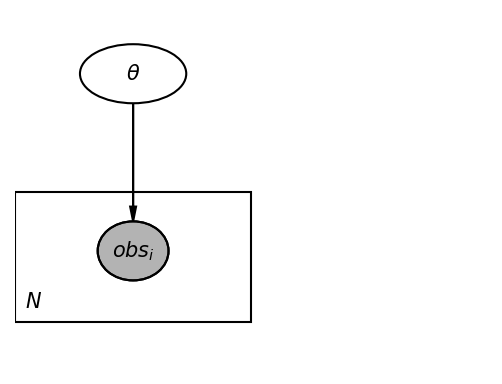

In [8]:
pgm = daft.PGM([4, 3], origin=[0, 0])
pgm.add_node(daft.Node("theta", r"$\theta$", 1, 2.5, aspect=1.8))

pgm.add_node(daft.Node("obs", r"$obs_i$", 1, 1, aspect=1.2, observed=True))

pgm.add_edge("theta", "obs")
pgm.add_plate([0, 0.5, 2, 1.0], label=r"$N$", shift=-0.1)
_ = pgm.render(dpi=150)

In [9]:
def neg_log_likelihood(theta, dataset):
    distribution_obj = dist.Bernoulli(probs=theta)
    return -distribution_obj.log_prob(dataset).sum()

We can find the likelihood for different thetas.

In [10]:
neg_log_likelihood(0.2, dataset_100), neg_log_likelihood(0.6, dataset_100)

(DeviceArray(127.67273, dtype=float32), DeviceArray(60.81372, dtype=float32))

We can also use `vmap` to compute the likelihood over a range of thetas.

In [11]:
# None for second argument as we don't need vmap for dataset
neg_log_likelihood_vmap = jax.vmap(neg_log_likelihood, in_axes=(0, None)) 

In [12]:
theta_array = jnp.linspace(0.01, 0.99, 100)
nll_array = neg_log_likelihood_vmap(theta_array, dataset_100)

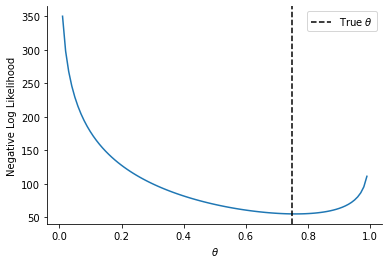

In [13]:
plt.plot(theta_array, nll_array)
sns.despine()
plt.axvline(0.75, linestyle='--', color='k', label=r'True $\theta$')
plt.legend()
plt.ylabel("Negative Log Likelihood")
_ = plt.xlabel(r"$\theta$")

### Learning MLE parameters via gradient descent

In [14]:
# We need gradient only respect to the first argument
grad_loss = jax.grad(neg_log_likelihood)

In [15]:
grad_loss(0.5, dataset_100)

DeviceArray(-104., dtype=float32, weak_type=True)

In [16]:
grad_loss(0.8, dataset_100)

DeviceArray(25.000008, dtype=float32, weak_type=True)

We can see that the gradient values starting with $\theta = 0.5$ will push towards increasing $\theta$ and vice versa starting with $\theta = 0.8$

In [61]:
optimizer = optax.sgd(learning_rate=0.001)

theta = jnp.array(0.1).round(2)

opt_state = optimizer.init(theta)

In [62]:
table = Table(title="MLE Convergence")

table.add_column("Iteration", justify="right", style="cyan", no_wrap=True)
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Theta", justify="right", style="green")


for i in range(10):
    cost_val = neg_log_likelihood(theta, dataset_100)
    table.add_row(str(i), f"{cost_val:0.2f}", f"{theta:0.2f}")
    grad_theta_val = grad_loss(theta, dataset_100)
    updates, opt_state = optimizer.update(grad_theta_val, opt_state)
    theta = optax.apply_updates(theta, updates)
print(table)

       MLE Convergence        
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Iteration ┃   Loss ┃ Theta ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│         0 │ 177.53 │  0.10 │
│         1 │  56.86 │  0.83 │
│         2 │  55.23 │  0.78 │
│         3 │  55.13 │  0.77 │
│         4 │  55.11 │  0.76 │
│         5 │  55.11 │  0.76 │
│         6 │  55.11 │  0.76 │
│         7 │  55.11 │  0.76 │
│         8 │  55.11 │  0.76 │
│         9 │  55.11 │  0.76 │
└───────────┴────────┴───────┘

### MAP

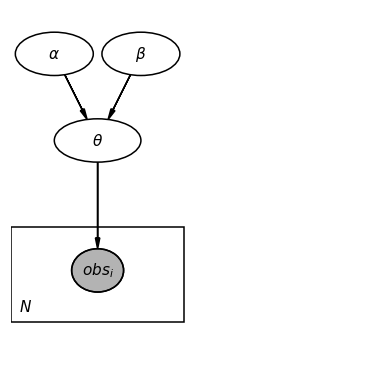

In [66]:
pgm = daft.PGM([4, 4], origin=[0, 0])
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 3.5, aspect=1.8))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 3.5, aspect=1.8))


pgm.add_node(daft.Node("theta", r"$\theta$", 1, 2.5, aspect=2))

pgm.add_node(daft.Node("obs", r"$obs_i$", 1, 1, aspect=1.2, observed=True))

pgm.add_edge("theta", "obs")
pgm.add_edge("alpha", "theta")
pgm.add_edge("beta", "theta")


pgm.add_plate([0, 0.5, 2, 1.0], label=r"$N$", shift=-0.1)
_ = pgm.render(dpi=110)

In [128]:
prior_alpha = 10.0
prior_beta = 10.0
prior_dist = dist.Beta(concentration1=prior_alpha, concentration0=prior_beta)

Our prior will give us samples on $\theta$. Let us draw a 100 samples and draw their histogram.

In [129]:
prior_samples = prior_dist.sample(sample_shape=(100), seed=key)

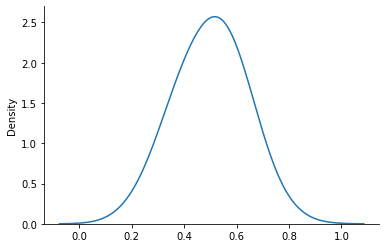

In [130]:
sns.kdeplot(prior_samples, bw_adjust=2)
sns.despine()

Now, given a $\theta$, we can evaluate the log prior and log likelihood and optimize their sum them to obtain the MAP estimate.

In [81]:
def neg_log_prior(theta, prior_dist):
    return -prior_dist.log_prob(theta)

In [82]:
neg_log_prior(0.1, prior_dist)

DeviceArray(7.9352818, dtype=float32)

In [83]:
neg_log_prior(0.5, prior_dist)

DeviceArray(-1.2595797, dtype=float32)

Clearly, we are much more likely to sample $\theta = 0.5$ from our prior in comparison to $\theta = 0.1$.

In [97]:
def joint_neg_log_prior_log_likelihood(theta, dataset, prior_dist):
    return neg_log_prior(theta, prior_dist) + neg_log_likelihood(theta, dataset)

In [98]:
grad_loss = jax.grad(joint_neg_log_prior_log_likelihood)
optimizer = optax.sgd(learning_rate=0.001)

theta = jnp.array(0.1).round(2)

opt_state = optimizer.init(theta)

In [99]:
table = Table(title="MAP Convergence")

table.add_column("Iteration", justify="right", style="cyan", no_wrap=True)
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Theta", justify="right", style="green")


for i in range(10):
    cost_val = joint_neg_log_prior_log_likelihood(theta, dataset_100, prior_dist)
    table.add_row(str(i), f"{cost_val:0.2f}", f"{theta:0.2f}")
    grad_theta_val = grad_loss(theta, dataset_100, prior_dist)
    updates, opt_state = optimizer.update(grad_theta_val, opt_state)
    theta = optax.apply_updates(theta, updates)
print(table)

       MAP Convergence        
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Iteration ┃   Loss ┃ Theta ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│         0 │ 185.46 │  0.10 │
│         1 │  74.68 │  0.91 │
│         2 │  58.55 │  0.63 │
│         3 │  56.80 │  0.67 │
│         4 │  56.33 │  0.70 │
│         5 │  56.22 │  0.71 │
│         6 │  56.20 │  0.72 │
│         7 │  56.20 │  0.72 │
│         8 │  56.19 │  0.72 │
│         9 │  56.19 │  0.72 │
└───────────┴────────┴───────┘

In [102]:
f"{(dataset_100.sum()+10)/(120):0.2f}"

'0.72'

### Analytical Posterior

$$P(\theta|Data) \sim Beta(\#Heads~in~Data + \alpha, \#Tails~in~Data + \beta)$$

In [121]:
analytical_posterior = dist.Beta(dataset_100.sum() + prior_alpha., 100.-dataset_100.sum() + prior_beta)

In [138]:
analytical_posterior.concentration1, analytical_posterior.concentration0

(DeviceArray(86., dtype=float32, weak_type=True),
 DeviceArray(34., dtype=float32, weak_type=True))

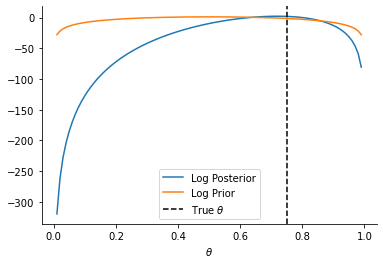

In [136]:
plt.plot(theta_array, analytical_posterior.log_prob(theta_array), label='Log Posterior')
plt.plot(theta_array, prior.log_prob(theta_array), label='Log Prior')
plt.axvline(0.75, linestyle='--', color='k', label=r'True $\theta$')


sns.despine()
_ = plt.xlabel(r"$\theta$")
plt.legend()

### Variational Inference
#### TODO below this point

In [133]:
q_alpha = jnp.array(2.)
q_beta = jnp.array(2.)

q = dist.Beta(q_alpha, q_beta)

In [107]:
def elbo(q_alpha, q_beta, dataset, prior_dist):
    q = dist.Beta(q_alpha, q_beta)
    return joint_neg_log_prior_log_likelihood(theta, dataset, prior_dist) - neg_log_prior(theta, q)

In [116]:
grad_elbo = jax.grad(elbo, argnums=[0, ])

NameError: name 'grad' is not defined

In [109]:
elbo(0.1, dataset_100, prior_dist, 2., 2.)

DeviceArray(184.84422, dtype=float32)

In [111]:
elbo(0.1, dataset_100, prior_dist, 10., 10.)

DeviceArray(177.52512, dtype=float32)

In [112]:
elbo(0.1, dataset_100, prior_dist, 11., 11.)

DeviceArray(176.55226, dtype=float32)

In [113]:
elbo(0.1, dataset_100, prior_dist, 40., 40.)

DeviceArray(147.5781, dtype=float32)

In [115]:
elbo(0.1, dataset_100, prior_dist, dataset_100.sum()+10.0, (100-dataset_100.sum()+10.0))

DeviceArray(58.46759, dtype=float32)